In [501]:
# Setup

!pip install pyro-ppl
!pip install scipy
!pip install matplotlib
!pip install scikit-optimize

     |████████████████████████████████| 80 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 2.1 MB/s eta 0:00:01
Processing /Users/alexkotlar/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653/PyYAML-5.3.1-cp37-cp37m-macosx_10_9_x86_64.whl


In [7]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
# from torch.distributions import Binomial, Gamma, Uniform
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple
import time
seed = 0

In [8]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.17167901992797852
Done
Tensor version took: 3.7984280586242676
Done
Tensor convert array version took: 0.12003588676452637


In [9]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [10]:
# Likelihood functions
# These assume univariate currently

# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - pD*pVgivenD) / (1 - pD)
    assert(p >= 0)
    return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

def llUnivariateSingleGeneJensen(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    global i
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
#     return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    global i
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        pDgivenV = params[0]
        pi1 = params[1]
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("returning inf")
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                continue

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)

            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                continue
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSumsAll = altCountsByGene[:, 0, :].sum(1)
    
    toKeep = []
    for i in range(len(geneSumsAll)):
        if geneSumsAll[i] == 0:
            print(f"skipping {i}")
            continue
            print(f"keeping {i}")
        toKeep.append(i)
        
    caseAltCounts = altCountsByGene[toKeep, 0, 1]
    geneSums = geneSumsAll[toKeep]
    
    print("shapes", caseAltCounts.shape, geneSumsAll.shape)
    pD = pDs[0]
    print("pd", pD)
    print("geneSums shape", geneSums.shape)

    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        print(f"params are {params}")
        pi1 = params[0]
        pDgivenV = params[1]
        print("pDgivenV", pDgivenV)
        pi0 = 1.0 - pi1
        
        print("pi0",pi0)
        
        if(pDgivenV > 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("bad, returning")
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        
        component0 = binomH0.log_prob(caseAltCounts)
        print("binomH0 at the bad place of 6780", component0[6779:6782], "where the sums are", geneSums[6779:6782], "and probs are", pD, "and altCounts are", caseAltCounts[6779:6782])
        component1 = binomH1.log_prob(caseAltCounts)
#         component0[component0 == float("-inf")] = 0
#         component1[component1 == float("-inf")] = 0
        component0 = pi0 * component0
        component1 = pi1 * component1
#         x = torch.Tensor([1, float("Inf"), 2, float("Inf")])
#         x[x == float("Inf")] = 0
#         x  # should be 1, 0, 2, 0 now
        
        
        print("components", component0, component1)
        ll = -(component1 + component0).sum()
        return ll
    
    return likelihood

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 100):
    costFn = likelihoodUnivariateFast(altCountsByGene, pDs)
    
    res = {"ll": [], "parameters": []}
    lls = res["ll"]
    params = res["parameters"]

    minLLDiff = 1
    minLLThresholdCount = 50
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)
    randomDist2 = Uniform(0, 1)
    fnArgs = [0, 0]
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    nGenes = len(altCountsByGene)
    pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
    pi1Bounds = ( 1/nGenes,  1 )
    bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        print(f"epoch {i}")
        # pDgivenV
        fnArgs[0] = randomDist.sample()
        # diseaseFraction
        fnArgs[1] = randomDist2.sample()
        fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        print(fit)
        if not fit["success"] is True:
            print("Failed to converge")
            print(fit)
            continue
        
        ll = fit["fun"]
        pDgivenV, pi1 = fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 0 or pi1 > 1:
            print("Failed to converge")
            print(fit)
            continue

        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            thresholdHitCount = 0
            print(f"fit: {fit}")
            lls.append(ll)
            params.append(fit["x"])
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return res

In [19]:
#this gives -2.401 log(likelihoodUnivariateSingleGene(xCtrl = 10, xCase1 = 1, prevalence1 = .01, pi0 = .9, pi1 = .1, pDiseaseGivenVariant = .001))
#tensor(-2.5290): llUnivariateSingleGeneJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
r = llUnivariateSingleGene(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
assert(abs(-r + tensor(-2.4010)) < .1)

In [21]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases

def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    for geneIdx in range(nGenes):
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
            geneProbs.append([probVgivenNotD, probVgivenD])
        probs.append(geneProbs)
    probs = tensor(probs)
    print("probs", probs, probs.shape)
    # This should not be slow but is
    # https://github.com/pytorch/pytorch/issues/11389
    start = time.time()
    altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
    print("final sampling took", time.time() - start)
    
    return altCounts, probs

def genDataSequential(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            altCountsCases = Binomial(total_count=nSamples[conditionIdx][1], probs=probVgivenD).sample()
            
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            altCountsCtrls = Binomial(total_count=nSamples[conditionIdx][0], probs=probVgivenNotD).sample()
            
            geneAltCounts.append([altCountsCtrls, altCountsCases])
            geneProbs.append([probVgivenNotD, probVgivenD])
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    print("geneAltCounts", altCounts, altCounts.shape, "probs", probs, probs.shape)
    
    return altCounts, probs

In [22]:
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDs = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)
pooledControls = True
altCountsByGene, afsByGene = genData(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
probs tensor([[[1.0892e-04, 1.0116e-03],
         [1.0437e-04, 1.4670e-03],
         [1.1751e-04, 4.7155e-04]],

        [[6.9348e-05, 7.8663e-04],
         [6.7408e-05, 9.8061e-04],
         [7.6207e-05, 3.1871e-04]],

        [[4.8966e-05, 6.9965e-04],
         [4.3746e-05, 1.2217e-03],
         [5.5278e-05, 1.8643e-04]],

        ...,

        [[5.2811e-05, 6.6529e-05],
         [5.3125e-05, 3.5082e-05],
         [5.2933e-05, 6.6857e-05]],

        [[1.0414e-04, 1.1997e-04],
         [1.0397e-04, 1.3695e-04],
         [1.0432e-04, 8.4768e-05]],

        [[1.0143e-04, 1.2757e-04],
         [1.0145e-04, 1.2540e-04],
         [1.0169e-04, 9.3056e-05]]]) torch.Size([20000, 3, 2])
final sampling took 

In [24]:
print("altCountsByGene", altCountsByGene, "afsByGene", afsByGene)

altCountsByGene tensor([[[ 9.,  0.],
         [14.,  3.],
         [14.,  0.]],

        [[11.,  0.],
         [ 9.,  1.],
         [ 8.,  0.]],

        [[ 5.,  1.],
         [ 4.,  2.],
         [ 3.,  0.]],

        ...,

        [[ 8.,  0.],
         [13.,  0.],
         [ 3.,  0.]],

        [[ 7.,  0.],
         [17.,  0.],
         [17.,  0.]],

        [[11.,  0.],
         [13.,  0.],
         [11.,  0.]]]) afsByGene tensor([[[1.0892e-04, 1.0116e-03],
         [1.0437e-04, 1.4670e-03],
         [1.1751e-04, 4.7155e-04]],

        [[6.9348e-05, 7.8663e-04],
         [6.7408e-05, 9.8061e-04],
         [7.6207e-05, 3.1871e-04]],

        [[4.8966e-05, 6.9965e-04],
         [4.3746e-05, 1.2217e-03],
         [5.5278e-05, 1.8643e-04]],

        ...,

        [[5.2811e-05, 6.6529e-05],
         [5.3125e-05, 3.5082e-05],
         [5.2933e-05, 6.6857e-05]],

        [[1.0414e-04, 1.1997e-04],
         [1.0397e-04, 1.3695e-04],
         [1.0432e-04, 8.4768e-05]],

        [[1.0143e-04,

In [ ]:
start = time.time()
altCountsByGene2, afsByGene2 = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
print("took",time.time()-start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])


In [ ]:
fitFnUniveriate(altCountsByGene, pDs)

In [498]:
costFn([1e-9, .999999])

skipping 279
skipping 749
skipping 1870
skipping 2200
skipping 3657
skipping 4502
skipping 7043
skipping 7262
skipping 8215
skipping 9542
skipping 9997
skipping 10536
skipping 11799
skipping 11988
skipping 12953
skipping 13479
skipping 14110
skipping 14959
skipping 18281
skipping 18547


tensor(51671.0195)

In [547]:
print(costFn([1e-9, 1e-9]))

skipping 279
skipping 749
skipping 1870
skipping 2200
skipping 3657
skipping 4502
skipping 7043
skipping 7262
skipping 8215
skipping 9542
skipping 9997
skipping 10536
skipping 11799
skipping 11988
skipping 12953
skipping 13479
skipping 14110
skipping 14959
skipping 18281
skipping 18547
tensor(11131.0996)


In [89]:
binomH0 = Binomial(total_count=tensor([1.,1]), probs=pDs[0])

In [90]:
binomH0.log_prob(tensor(1.))

tensor([-4.6151, -4.6151])

In [94]:
costFn2 = likelihoodUnivariateFast(altCountsByGene, pDs)
# print(costFn2([1e-9, .999999]))
print(costFn2([1e-9, 1e-9]))
print(costFn2([0.1,.1]))

# best result from R
#  0.08845797           0.11094360 , ll -10127.23
# pDgivenV, pi1


skipping 6780
skipping 7044
skipping 7241
skipping 7579
skipping 11089
skipping 11642
skipping 11813
skipping 12044
skipping 12389
skipping 15026
skipping 16708
shapes torch.Size([19989]) torch.Size([20000])
pd tensor(0.0099)
geneSums shape torch.Size([19989])
params are [1e-09, 1e-09]
pDgivenV 1e-09
pi0 0.999999999
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0896, -0.1194]) where the sums are tensor([14.,  9., 12.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 0.])
components tensor([-4.9830, -7.6468, -2.4975,  ..., -0.0398, -3.0455, -0.1095]) tensor([-2.7528e-08, -4.1499e-08, -1.3745e-08,  ..., -4.7684e-16,
        -1.4333e-08, -1.9073e-15])
tensor(11074.7295)
params are [0.1, 0.1]
pDgivenV 0.1
pi0 0.9
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0896, -0.1194]) where the sums are tensor([14.,  9., 12.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 0.])
components tensor([-4.4847, -6.8821, -2.2477,  ..., -0.0358, -2.7409, -0.0985])

In [96]:
costFn = likelihoodUnivariate(altCountsByGene, pDs)
print("costFn1:", costFn([.001, .01]),"costFn2:",costFn2([.001, .01]))

skipping 6780
skipping 7044
skipping 7241
skipping 7579
skipping 11089
skipping 11642
skipping 11813
skipping 12044
skipping 12389
skipping 15026
skipping 16708
params are [0.001, 0.01]
pDgivenV 0.01
pi0 0.999
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0896, -0.1194]) where the sums are tensor([14.,  9., 12.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 0.])
components tensor([-4.9780, -7.6391, -2.4950,  ..., -0.0398, -3.0424, -0.1093]) tensor([-4.9642e-03, -7.6182e-03, -2.4883e-03,  ..., -4.0201e-05,
        -3.0359e-03, -1.1055e-04])
costFn1: tensor(11085.6865) costFn2: tensor(11074.6982)


In [49]:
costFn([0.0001,0.11094360])

skipping 6780
skipping 7044
skipping 7241
skipping 7579
skipping 11089
skipping 11642
skipping 11813
skipping 12044
skipping 12389
skipping 15026
skipping 16708


tensor(12764.8105)

In [60]:
print(costFn2([0.0001,0.11094360]))

params are [0.0001, 0.1109436]
pDgivenV 0.1109436
pi0 0.9999
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0000, -0.0896]) where the sums are tensor([14.,  0.,  9.])
components tensor([-4.9825, -7.6460, -2.4972,  ..., -0.0398, -3.0452, -0.1094]) tensor([-1.3343e-04, -1.7970e-04, -9.4227e-05,  ..., -4.7038e-05,
        -1.0597e-04, -1.2935e-04])
tensor(11075.9297)


In [68]:
d = Binomial(total_count=tensor([14., 0., 9.]), probs=tensor(.0099))
d.log_prob(tensor([0.,0.,0.]))

tensor([-0.1393, -0.0000, -0.0895])

In [551]:
costFn2([1e-9, .999999])

params are [1e-09, 0.999999]
pDgivenV 1e-09
pi0 1.0000000000287557e-06
components tensor([-6.9653e-08, -9.4742e-06, -4.8388e-06,  ..., -8.9553e-08,
        -1.1940e-07, -4.9752e-08]) tensor([-9.5367e-07, -4.3396e+01, -2.7374e+01,  ..., -9.5367e-07,
        -1.9073e-06, -4.7684e-07])
ll: -51670.8515625


-51670.8515625

In [546]:
binomH0 = Binomial(total_count=geneSums, probs=.001)
binomH1 = Binomial(total_count=geneSums, probs=.01)
caseAltCounts = altCountsByGene[:, 0, 1]
print(caseAltCounts)
component0 = binomH0.log_prob(caseAltCounts)
print("component0", component0, .5*component0)
component1 = binomH1.log_prob(caseAltCounts)

tensor([0., 3., 2.,  ..., 0., 0., 0.])
component0 tensor([-1.0005e-02, -1.5943e+01, -9.0420e+00,  ..., -1.5007e-02,
        -5.0025e-03, -1.2007e-02]) tensor([-5.0025e-03, -7.9714e+00, -4.5210e+00,  ..., -7.5035e-03,
        -2.5012e-03, -6.0034e-03])


In [476]:
pDgivenV(pDs[0], afsByGene2[0:2000, 0, 1].mean(), afMean)

tensor(0.0987)

In [473]:
condition1 = altCountsByGene2[:, 0, :]
condition1
pDs[0]

afsByGene2[0:2000,:,1].mean()

tensor(0.0008)

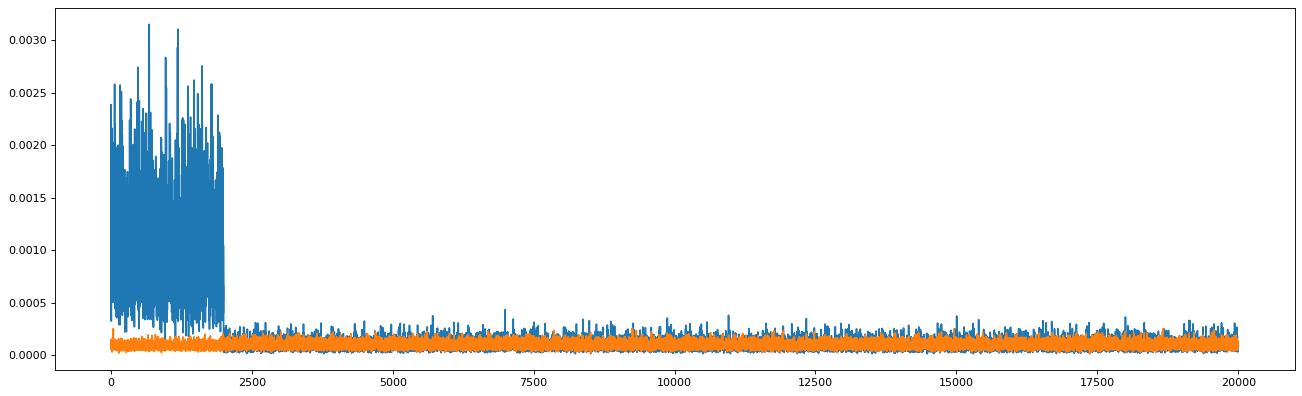

In [472]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene2[:, 0, 1:2].flatten())
pyplot.plot(afsByGene2[:, 0, 0:1].flatten())



In [312]:
start = time.time()

l = likelihoodUnivariateFast(altCountsByGene, pDs)

print(l(.001, .01))

time.time() - start

gene sums tensor([10., 10., 16.,  8., 11.,  5., 18.,  4., 19., 12.])
component0 tensor([-2.3691, -0.0995, -0.1592, -2.5701, -0.1094, -0.0497, -1.8668, -0.0398,
        -1.8232, -5.0700])
component1 tensor([-4.6142e-02, -1.0005e-04, -1.6008e-04, -4.8353e-02, -1.1005e-04,
        -5.0025e-05, -4.0344e-02, -4.0021e-05, -3.9813e-02, -9.6359e-02])
tensor(11285.2695)


0.007719278335571289

In [318]:
print(l(0, 0))

component0 tensor([-2.3930, -0.1005, -0.1608, -2.5961, -0.1106, -0.0503, -1.8857, -0.0402,
        -1.8416, -5.1212])
component1 tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])
tensor(11215.3643)
